# LSST Camera Geometry

<br>Owner(s): **Alex Drlica-Wagner** ([@kadrlica](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@kadrlica)),
<br>Last Verified to Run: **2019-07-20**
<br>Verified Stack Release: **18.0.0**

### Learning Objectives:

Learn stack tools to interact with the LSST camera geometry.

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Setup
You can find the Stack version by using `eups list -s` on the terminal command line.

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-kadrlica-r18-0-0
lsst_distrib          18.0.0+1   	current v18_0_0 setup


In [14]:
import os
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

import lsst.daf.persistence as dafPersist
import lsst.afw.cameraGeom.utils as cgUtils
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from lsst.obs.lsst.cameraTransforms import ampPixelToCcdPixel

import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.geom as afwGeom

from lsst.afw.cameraGeom.cameraGeomLib import FIELD_ANGLE, FOCAL_PLANE

In [6]:
!echo "lsst.obs.lsst.imsim.ImsimMapper" > _mapper
!cat _mapper

lsst.obs.lsst.imsim.ImsimMapper


## Existing Tools

The stack provides a pre-wrapped visualization of the camera geometry, but I don't find it to be especially useful. Each detector is labeled with text that is too small to read. Rafts and amplifiers are not labeled. The focus and alignment sensors are not shown.

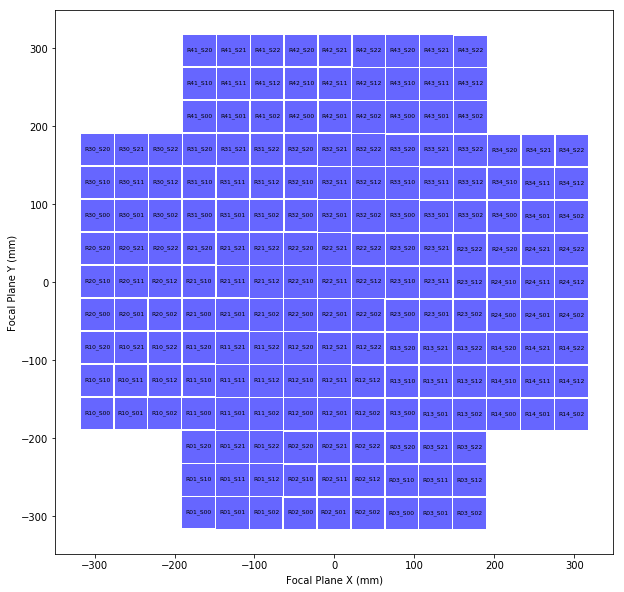

In [11]:
butler = dafPersist.Butler("./")
camera = butler.get('camera')
cgUtils.plotFocalPlane(camera)

As we learned before, we can find out what `cgUtils.plotFocalPlane` is doing by looking at the source code.

## Plot CCDs on Focal Plane

Let's start by breaking up the process. First, we'll work on plotting the CCDs on the LSST focal plane.

Text(0, 0.5, 'Focal Plane Y (mm)')

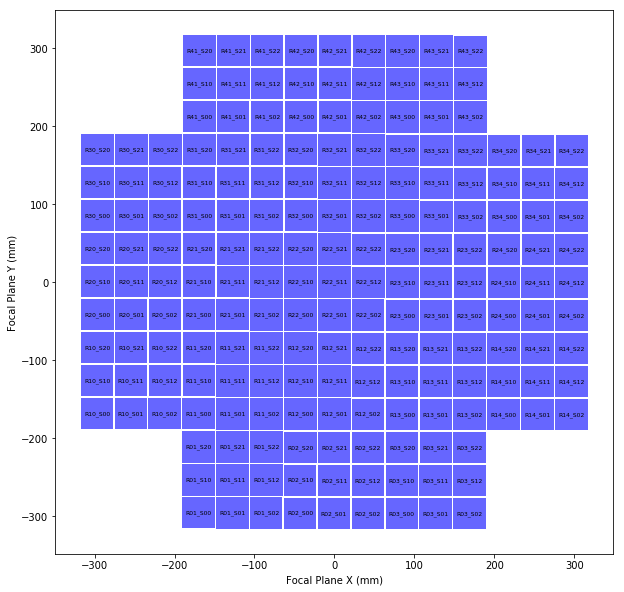

In [24]:
fig= plt.figure(figsize=(10,10))
ax = plt.gca()

xvals,yvals = [],[]
colors,patches = [],[]
for det in camera:
    corners = [(c.getX(), c.getY()) for c in det.getCorners(FOCAL_PLANE)]
    for corner in corners:
        xvals.append(corner[0])
        yvals.append(corner[1])
    colors.append('b')
    patches.append(Polygon(corners, True))
    center = det.getOrientation().getFpPosition()
    text = det.getName()
    ax.text(center.getX(), center.getY(), text,
            ha='center', va='center', size=6)

patchCollection = PatchCollection(patches, alpha=0.6, facecolor=colors)
ax.add_collection(patchCollection)

ax.set_xlim(min(xvals) - abs(0.1*min(xvals)),
            max(xvals) + abs(0.1*max(xvals)))
ax.set_ylim(min(yvals) - abs(0.1*min(yvals)),
            max(yvals) + abs(0.1*max(yvals)))
ax.set_xlabel('Focal Plane X (mm)')
ax.set_ylabel('Focal Plane Y (mm)')

## Plot Amps on a CCD

We'll start by grabbing the amps from a specific detector (the central detector R22,S11). We can then plot the extents of the amps in pixel coordinates.

Text(0, 0.5, 'CCD Y (pix)')

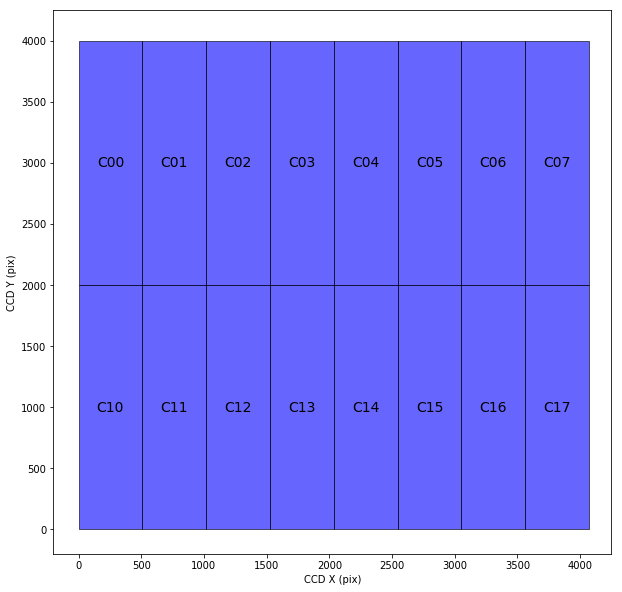

In [65]:
# Create the camera transformation
transform = LsstCameraTransforms(camera)
# Get the central detector
det = transform.getDetector('R22_S11')

# Get the amps for this detector
amps = det.getAmpInfoCatalog()

fig,ax = plt.subplots(1,figsize=(10,10))
patches,colors = [],[]
for amp in amps:
    corners = [(c.getX(), c.getY()) for c in amp.getBBox().getCorners()]
    patches.append(Polygon(corners, True))
    colors.append('b')
    center = amp.getBBox().getCenter()
    text = amp.getName()
    ax.text(center.getX(), center.getY(), text, color='k',
            ha='center', va='center', size=14)

# Add the patch collection
patchCollection = PatchCollection(patches, alpha=0.6, facecolor=colors,edgecolor='k')
ax.add_collection(patchCollection)

# Set some labels and extent
ax.set_xlim(-200,4250)
ax.set_ylim(-200,4250)
ax.set_xlabel('CCD X (pix)')
ax.set_ylabel('CCD Y (pix)')

Ok, so this is all well and good, but what if we want to plot the physical positions of the amps in focal plane coordinates? We should be able to do this with a transformation.

Text(0, 0.5, 'CCD Y (mm)')

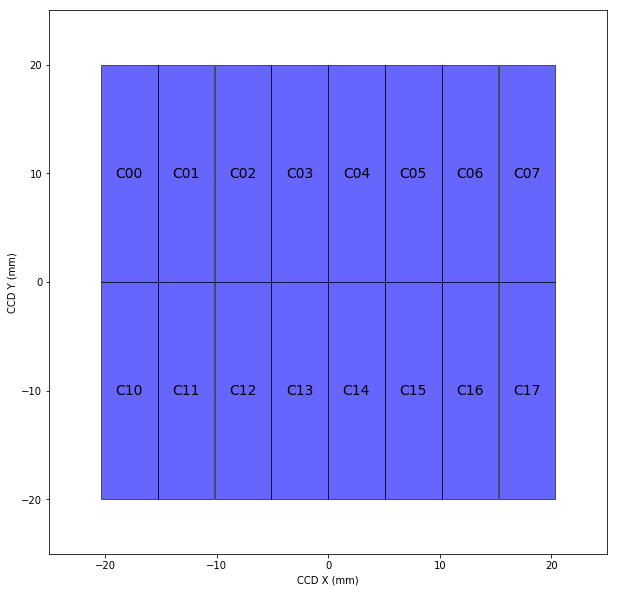

In [76]:
# Create the camera transformation
transform = LsstCameraTransforms(camera)
# Get the central detector
det = transform.getDetector('R22_S11')

# Get the amps for this detector
amps = det.getAmpInfoCatalog()

fig,ax = plt.subplots(1,figsize=(10,10))
patches,colors = [],[]
for amp in amps:
    points = [transform.ccdPixelToFocalMm(c.getX(), c.getY(), det.getName()) for c in amp.getBBox().getCorners()]
    corners = [(p.getX(),p.getY()) for p in points]

    patches.append(Polygon(corners, True))
    colors.append('b')
    # Center in pixels
    center_pix = amp.getBBox().getCenter()
    # center in mm
    center = transform.ccdPixelToFocalMm(center_pix.getX(),center_pix.getY(),det.getName())
    text = amp.getName()
    ax.text(center.getX(), center.getY(), text, color='k',
            ha='center', va='center', size=14)

# Add the patch collection
patchCollection = PatchCollection(patches, alpha=0.6, facecolor=colors,edgecolor='k')
ax.add_collection(patchCollection)

# Set some labels and extent
ax.set_xlim(-25,25)
ax.set_ylim(-25,25)
ax.set_xlabel('CCD X (mm)')
ax.set_ylabel('CCD Y (mm)')

## New Tools

I'd like to try to replicate the image [here](https://confluence.lsstcorp.org/display/LSWUG/Representation+of+a+Camera?preview=/4129064/10190878/LSST_FocalPlane.png#/).

In [12]:
def plotFancyFocalPlane(camera, fieldSizeDeg_x=0, fieldSizeDeg_y=None, 
                        dx=0.1, dy=0.1, figsize=(10., 10.),
                        useIds=False, showFig=True, savePath=None):
    """Make a plot of the focal plane along with a set points that sample
    the field of view.
 
    Parameters
    ----------
    camera : `lsst.afw.cameraGeom.Camera`
        A camera object
    fieldSizeDeg_x : `float`
        Amount of the field to sample in x in degrees
    fieldSizeDeg_y : `float` or `None`
        Amount of the field to sample in y in degrees
    dx : `float`
        Spacing of sample points in x in degrees
    dy : `float`
        Spacing of sample points in y in degrees
    figsize : `tuple` containing two `float`
        Matplotlib style tuple indicating the size of the figure in inches
    useIds : `bool`
        Label detectors by name, not id?
    showFig : `bool`
        Display the figure on the screen?
    savePath : `str` or `None`
        If not `None`, save a copy of the figure to this name.
    """
    try:
        from matplotlib.patches import Polygon
        from matplotlib.collections import PatchCollection
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError(
            "Can't run plotFocalPlane: matplotlib has not been set up")
 
    if fieldSizeDeg_x:
        if fieldSizeDeg_y is None:
            fieldSizeDeg_y = fieldSizeDeg_x
 
        field_gridx, field_gridy = numpy.meshgrid(
            numpy.arange(0., fieldSizeDeg_x + dx, dx) - fieldSizeDeg_x/2.,
            numpy.arange(0., fieldSizeDeg_y + dy, dy) - fieldSizeDeg_y/2.)
        field_gridx, field_gridy = field_gridx.flatten(), field_gridy.flatten()
    else:
        field_gridx, field_gridy = [], []
 
    xs = []
    ys = []
    pcolors = []
 
    # compute focal plane positions corresponding to field angles field_gridx, field_gridy
    posFieldAngleList = [lsst.geom.Point2D(x*lsst.geom.radians, y*lsst.geom.radians)
                         for x, y in zip(field_gridx, field_gridy)]
    posFocalPlaneList = camera.transform(posFieldAngleList, FIELD_ANGLE, FOCAL_PLANE)

    transform = LsstCameraTransforms(camera)

    for posFocalPlane in posFocalPlaneList:
        xs.append(posFocalPlane.getX())
        ys.append(posFocalPlane.getY())
        dets = camera.findDetectors(posFocalPlane, FOCAL_PLANE)
        if len(dets) > 0:
            pcolors.append('w')
        else:
            pcolors.append('k')
 
    colorMap = {0: 'skyblue', 1: 'y', 2: 'g', 3: 'r'}
 
    patches = []
    colors = []
    plt.figure(figsize=figsize)
    ax = plt.gca()
    xvals = []
    yvals = []
    for det in camera:
        corners = [(c.getX(), c.getY()) for c in det.getCorners(FOCAL_PLANE)]
        for corner in corners:
            xvals.append(corner[0])
            yvals.append(corner[1])
        colors.append(colorMap[det.getType()])
        patches.append(Polygon(corners, True))
        center = det.getOrientation().getFpPosition()
        name = det.getName()

        if name.startswith('R22'):
            if name.endswith('S11'):
                #amp_patches = []
                #scale = (corners[0][0] - corners[1][0])/4096.
                #for amp in det.getAmpInfoCatalog():
                #    amp_corners = [(c.getX()*scale-corners[0][0], c.getY()*scale-corners[0][1]) for c in amp.getBBox().getCorners()]
                #    amp_patches.append(Polygon(amp_corners, True))
                #patchCollection = PatchCollection(amp_patches, alpha=0.6, facecolor='none',edgecolor='k')
                #ax.add_collection(patchCollection)

                # https://github.com/lsst/obs_lsst/blob/master/python/lsst/obs/lsst/cameraTransforms.py#L171
                amp_patches = []
                for i,amp in enumerate(det.getAmpInfoCatalog()):
                    print(i,amp['hdu'])
                    amp_corners = [(c.getX(), c.getY()) for c in amp.getBBox().getCorners()]
                    print('amp pixels:',amp_corners)
                    #x_amp_corners = [transform.ampPixelToFocalMm(c[0],c[1],amp['hdu'],name) for c in amp_corners]
                    #x_amp_corners = [transform.ampPixelToCcdPixel(c[0],c[1],amp['hdu'],name) for c in amp_corners]
                    x_amp_corners = [ampPixelToCcdPixel(c[0], c[1], det, amp['hdu']) for c in amp_corners]
                    y_amp_corners = [(c.getX(), c.getY()) for c in x_amp_corners]
                    print('ccd pixels:',y_amp_corners)
                    z_amp_corners = [det.transform(afwGeom.Point2D(p), cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE) for p in x_amp_corners]
                    print('fp mm:',z_amp_corners)
                    amp_patches.append(Polygon(y_amp_corners, True))
                patchCollection = PatchCollection(amp_patches, alpha=0.6, facecolor='none',edgecolor='k')
                ax.add_collection(patchCollection)

            else:
                text = '(%s,%s)'%tuple(name.split('_')[-1].strip('S'))
                ax.text(center.getX(), center.getY(), text,
                        ha='center', va='center', size=10)
        elif name.endswith('S11'):
             text = '(%s,%s)'%tuple(name.split('_')[0].strip('R'))
             ax.text(center.getX(), center.getY(), text, color='0.3',
                     ha='center', va='center',size=18)
             
             
    patchCollection = PatchCollection(patches, alpha=0.6, facecolor=colors)
    ax.add_collection(patchCollection)

    ax.scatter(xs, ys, s=10, alpha=.7, linewidths=0., c=pcolors)
    ax.set_xlim(min(xvals) - abs(0.1*min(xvals)),
                max(xvals) + abs(0.1*max(xvals)))
    ax.set_ylim(min(yvals) - abs(0.1*min(yvals)),
                max(yvals) + abs(0.1*max(yvals)))
    ax.set_xlabel('Focal Plane X (mm)')
    ax.set_ylabel('Focal Plane Y (mm)')
    if savePath is not None:
        plt.savefig(savePath)
    if showFig:
        plt.show()


0 1
amp pixels: [(0, 0), (508, 0), (508, 1999), (0, 1999)]
ccd pixels: [(511, 0), (3, 0), (3, 1999), (511, 1999)]
fp mm: [Point2D(-15.255, -20.005), Point2D(-20.335, -20.005), Point2D(-20.335, -0.015), Point2D(-15.255, -0.015)]
1 2
amp pixels: [(509, 0), (1017, 0), (1017, 1999), (509, 1999)]
ccd pixels: [(511, 0), (3, 0), (3, 1999), (511, 1999)]
fp mm: [Point2D(-15.255, -20.005), Point2D(-20.335, -20.005), Point2D(-20.335, -0.015), Point2D(-15.255, -0.015)]
2 3
amp pixels: [(1018, 0), (1526, 0), (1526, 1999), (1018, 1999)]
ccd pixels: [(511, 0), (3, 0), (3, 1999), (511, 1999)]
fp mm: [Point2D(-15.255, -20.005), Point2D(-20.335, -20.005), Point2D(-20.335, -0.015), Point2D(-15.255, -0.015)]
3 4
amp pixels: [(1527, 0), (2035, 0), (2035, 1999), (1527, 1999)]
ccd pixels: [(511, 0), (3, 0), (3, 1999), (511, 1999)]
fp mm: [Point2D(-15.255, -20.005), Point2D(-20.335, -20.005), Point2D(-20.335, -0.015), Point2D(-15.255, -0.015)]
4 5
amp pixels: [(2036, 0), (2544, 0), (2544, 1999), (2036, 1999)]

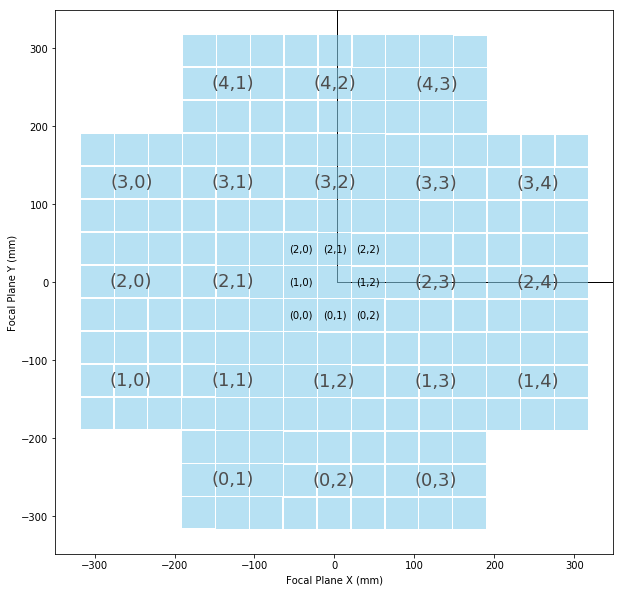

In [13]:
plotFancyFocalPlane(camera)